In [57]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel
import argparse, subprocess
from importlib import reload
import cmasher as cmr

In [22]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap1 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']
gal1s = pklload("./database/01_nh_ghmatch.pickle")
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp)

mode = 'nh2'
iout = 797
repo, rurmode, dp = mode2repo(mode)
snap2 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']
gal2s = pklload("./database/01_nh2_ghmatch.pickle")
hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp)

result1s = pklload(f"./database/03_MWA1s.pickle")
result2s = pklload(f"./database/03_MWA2s.pickle")

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


  0%|          | 0/54 [00:00<?, ?it/s]

 > Set box and sphere...


100%|██████████| 31/31 [00:00<00:00, 420.65it/s]


 > Load particles...
 > Load cells...
 > Mapping...
Computing particle map of 7810230 particles... 
Done (0.633s).
MinLvl = 13, MaxLvl = 19, Initial Image Size:  [2496 2432]
Drawing gas map... 
Done (4.469s).
Computing particle map of 2446706 particles... 
Done (0.237s).
MinLvl = 13, MaxLvl = 19, Initial Image Size:  [2496 2496]
Drawing gas map... 
Done (2.562s).
Computing particle map of 1213284 particles... 
Done (1.543s).
Computing particle map of 1154017 particles... 
Done (1.528s).
 > Drawing...


/tmp/ipykernel_29480/1060133380.py:134: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(dmmap1), origin='lower', extent=[*snap1.box[0], *snap1.box[1]], cmap=cmr.arctic, vmax=vmax_dm, vmin=vmin_dm)
/tmp/ipykernel_29480/1060133380.py:150: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(dmmap2), origin='lower', extent=[*snap2.box[0], *snap2.box[1]], cmap=cmr.arctic, vmax=vmax_dm, vmin=vmin_dm)
  0%|          | 0/54 [00:34<?, ?it/s]


ValueError: 'locs' must be 1D with shape (M,). Your input has shape ().

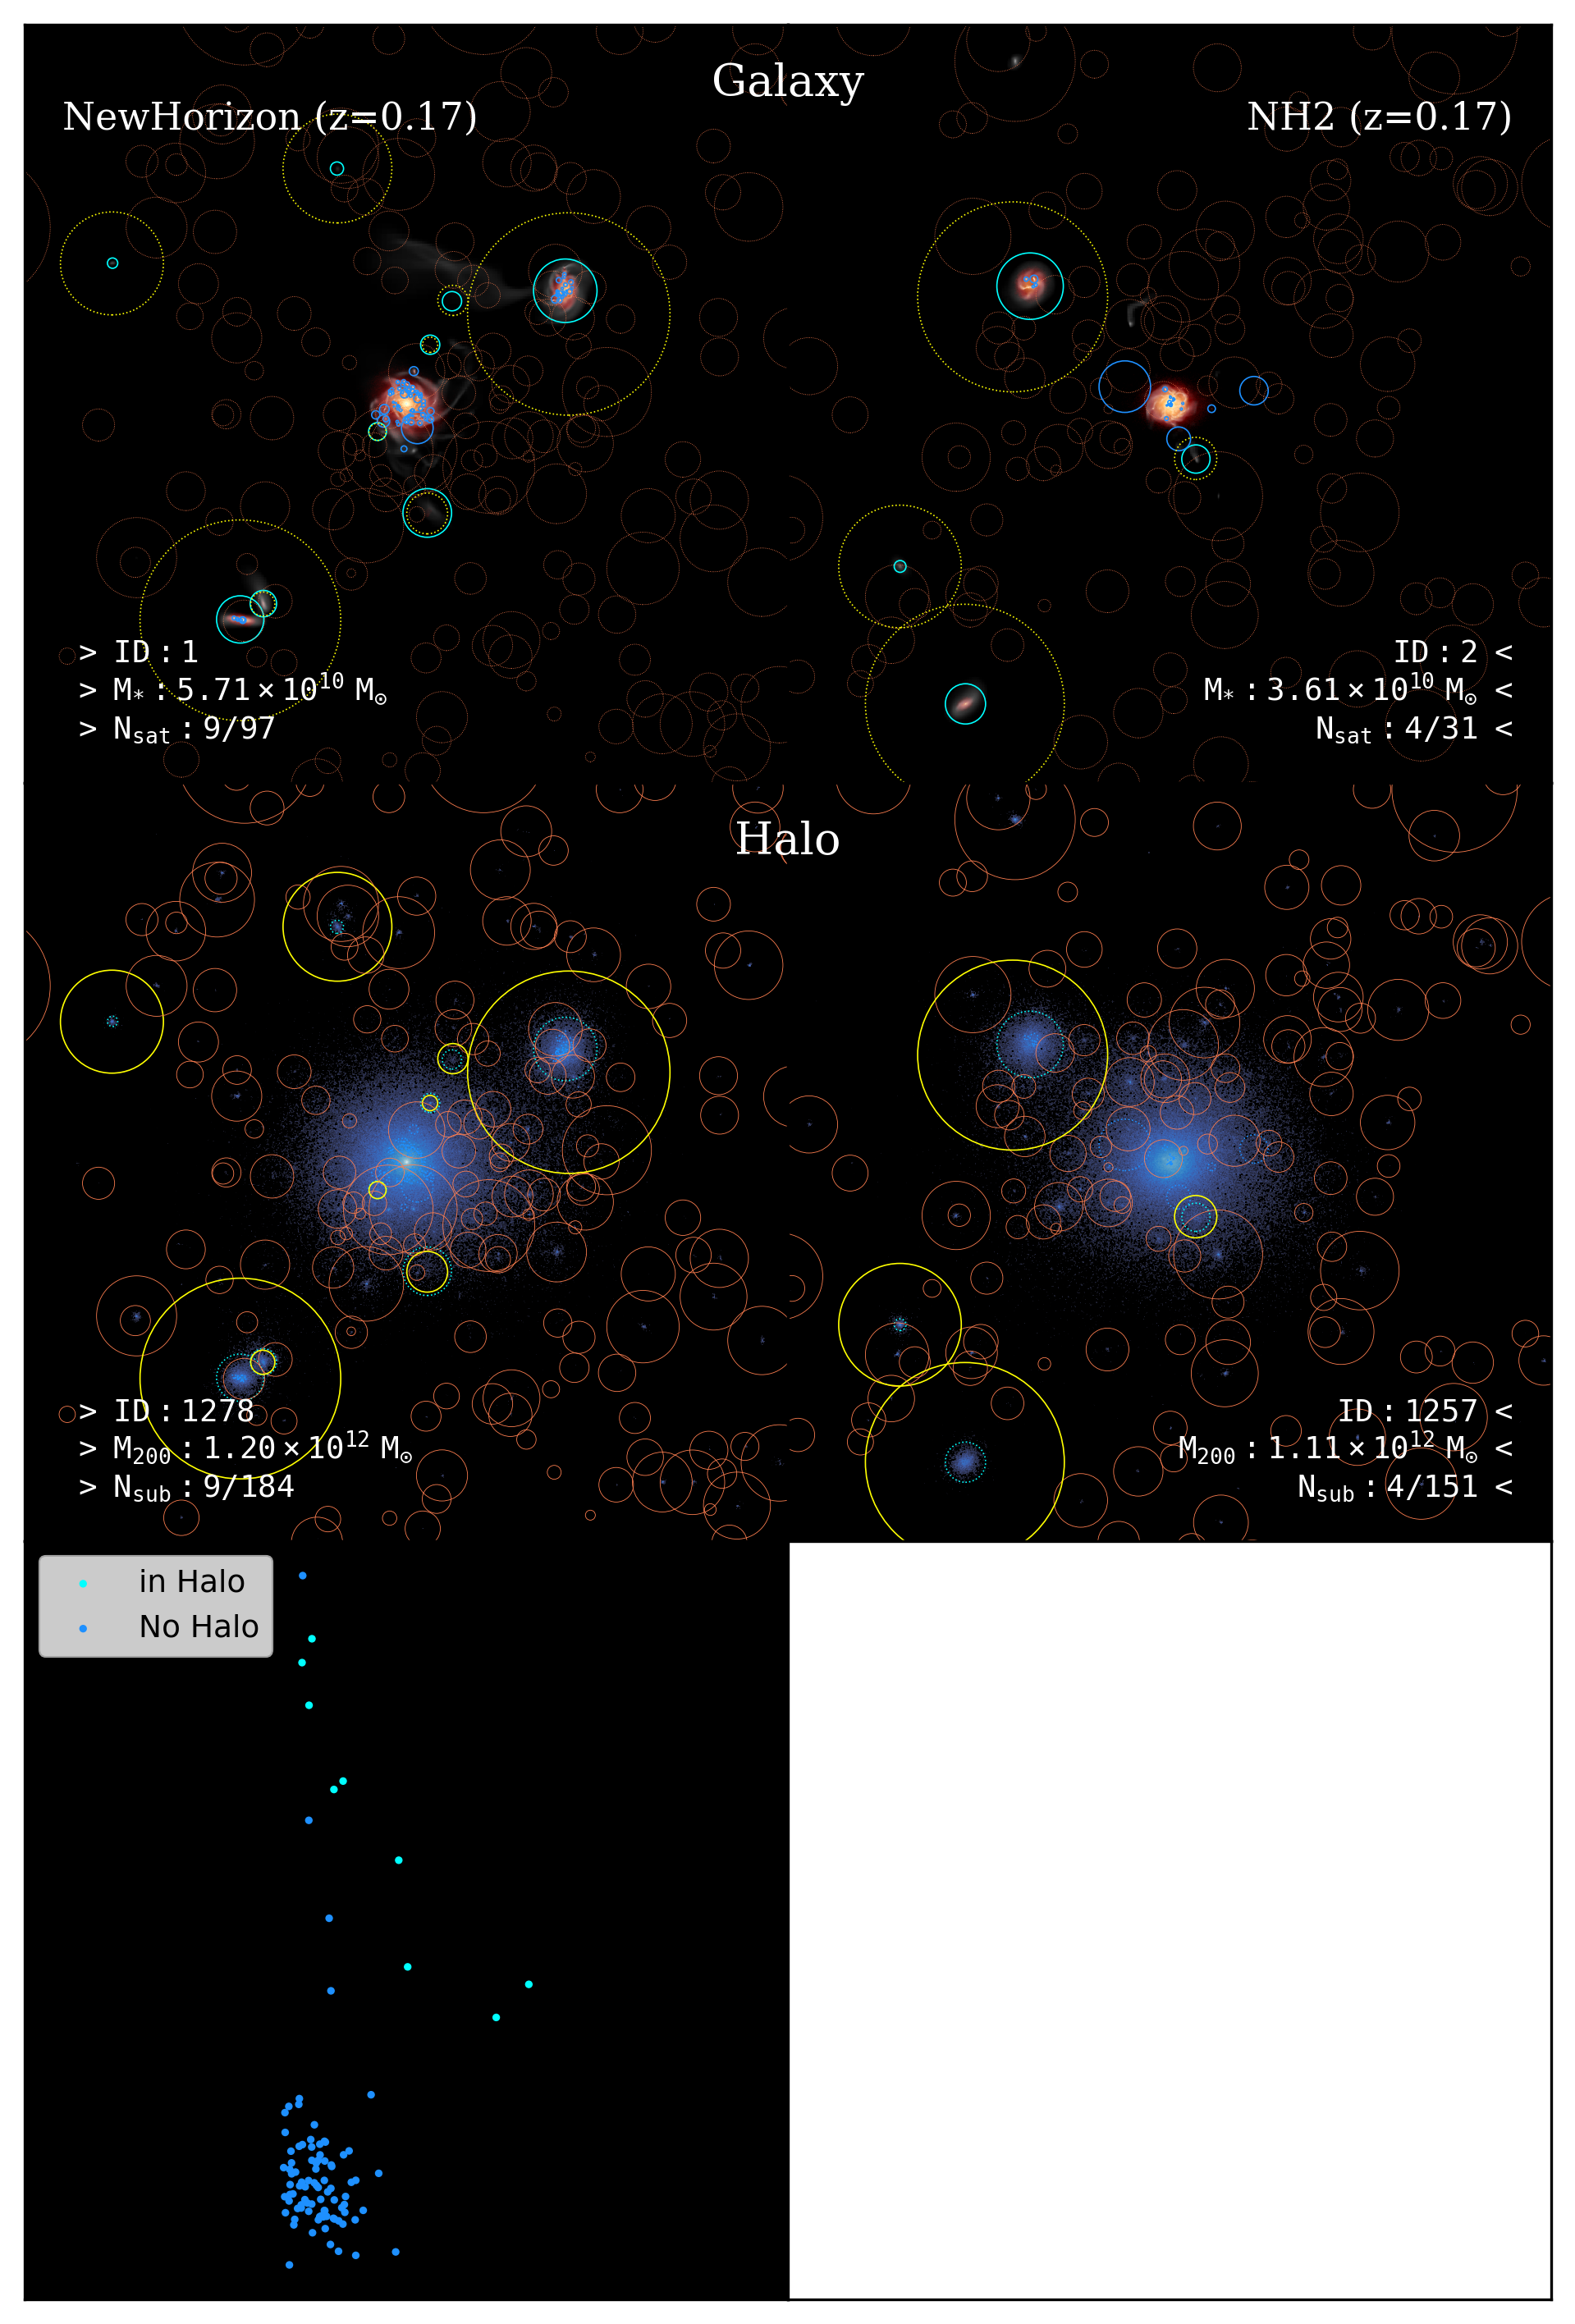

In [54]:
pdtype = np.dtype( [('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('epoch', '<f8'), ('metal', '<f8'), ('id', '<i4')] )
cdtype = np.dtype( [('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('rho', '<f8'), ('P', '<f8'), ('metal', '<f8'), ('level', '<i4')] )

gmap = plt.cm.gray
smap = plt.cm.afmhot
arr1 = {}
if(os.path.exists("./database/06_nh_subhalo_pairs.pickle")):
    arr1 = pklload("./database/06_nh_subhalo_pairs.pickle")
arr2 = {}
if(os.path.exists("./database/06_nh2_subhalo_pairs.pickle")):
    arr2 = pklload("./database/06_nh2_subhalo_pairs.pickle")
for MWA1, MWA2 in tqdm( zip(result1s, result2s), total=len(result1s) ):
    if(MWA['id'] in arr1.keys())and(MWA['id'] in arr2.keys()): continue
    arr1[MWA1['id']] = {}; arr2[MWA2['id']] = {}
    print(" > Set box and sphere...")
    rrange = max(MWA1['r200_code'], MWA2['r200_code'])*1.5
    snap1.set_box_halo(MWA1, radius=rrange, use_halo_radius=False)
    snap2.set_box_halo(MWA2, radius=rrange, use_halo_radius=False)
    sat1s = cut_box(gal1s, MWA1['x'], MWA1['y'], MWA1['z'], rrange, both_sphere=True)
    sat1s = sat1s[sat1s['id'] != MWA1['id']]
    age1s = np.zeros(len(sat1s))
    for i in tqdm( range(len(sat1s)) ):
        parts = uhmi.HaloMaker.read_member_part(snap1, sat1s[i]['id'], galaxy=True)
        age1s[i] = np.average(parts['age', 'Gyr'], weights=parts['m'])
    sat2s = cut_box(gal2s, MWA2['x'], MWA2['y'], MWA2['z'], rrange, both_sphere=True)
    sat2s = sat2s[sat2s['id'] != MWA2['id']]
    age2s = np.zeros(len(sat2s))
    for i in tqdm( range(len(sat2s)) ):
        parts = uhmi.HaloMaker.read_member_part(snap2, sat2s[i]['id'], galaxy=True)
        age2s[i] = np.average(parts['age', 'Gyr'], weights=parts['m'])
    sub1s = cut_box(hal1s, MWA1['x'], MWA1['y'], MWA1['z'], rrange, both_sphere=True)
    sub1s = sub1s[sub1s['id'] != MWA1['halo_id']]
    sub2s = cut_box(hal2s, MWA2['x'], MWA2['y'], MWA2['z'], rrange, both_sphere=True)
    sub2s = sub2s[sub2s['id'] != MWA2['halo_id']]

    print(" > Load particles...")
    table = pklload(f"./database/parts/nh_star_{MWA1['id']:04d}.pickle")
    star1 = np.empty(len(table), dtype=pdtype)
    for iname in pdtype.names: star1[iname] = table[iname]
    star1 = uri.Particle( cut_box(star1, MWA1['x'], MWA1['y'], MWA1['z'], rrange), snap1 )
    rband1 = measure_luminosity(star1, 'SDSS_r')
    table = pklload(f"./database/parts/nh2_star_{MWA2['id']:04d}.pickle")
    star2 = np.empty(len(table), dtype=pdtype)
    for iname in pdtype.names: star2[iname] = table[iname]
    star2 = uri.Particle( cut_box(star2, MWA2['x'], MWA2['y'], MWA2['z'], rrange), snap2 )
    rband2 = measure_luminosity(star2, 'SDSS_r')
    table = pklload(f"./database/parts/nh_dm_{MWA1['id']:04d}.pickle")
    dm1 = np.empty(len(table), dtype=pdtype)
    for iname in pdtype.names: dm1[iname] = table[iname]
    dm1 = uri.Particle( cut_box(dm1, MWA1['x'], MWA1['y'], MWA1['z'], rrange), snap1 )
    table = pklload(f"./database/parts/nh2_dm_{MWA2['id']:04d}.pickle")
    dm2 = np.empty(len(table), dtype=pdtype)
    for iname in pdtype.names: dm2[iname] = table[iname]
    dm2 = uri.Particle( cut_box(dm2, MWA2['x'], MWA2['y'], MWA2['z'], rrange), snap2 )
    print(" > Load cells...")
    table = pklload(f"./database/parts/nh_cell_{MWA1['id']:04d}.pickle")
    cell1 = np.empty(len(table), dtype=cdtype)
    for iname in cdtype.names: cell1[iname] = table[iname]
    cell1 = uri.Cell( cut_box(cell1, MWA1['x'], MWA1['y'], MWA1['z'], rrange), snap1 )
    table = pklload(f"./database/parts/nh2_cell_{MWA2['id']:04d}.pickle")
    cell2 = np.empty(len(table), dtype=cdtype)
    for iname in cdtype.names: cell2[iname] = table[iname]
    cell2 = uri.Cell( cut_box(cell2, MWA2['x'], MWA2['y'], MWA2['z'], rrange), snap2 )

    print(" > Mapping...")
    starmap1 = painter.partmap(star1, shape=1440, method='hist', weights=rband1)
    cellmap1 = painter.gasmap(cell1, shape=1440, minlvl=13, weights=cell1['rho'])
    starmap2 = painter.partmap(star2, shape=1440, method='hist', weights=rband2)
    cellmap2 = painter.gasmap(cell2, shape=1440, minlvl=13, weights=cell2['rho'])
    vmax_star = max(starmap1.max(), starmap2.max())
    vmax_cell = max(cellmap1.max(), cellmap2.max())
    combine1 = painter.composite_image([cellmap1, starmap1], [gmap, smap], mode='screen', qscales=[3.5, 4], vmaxs=[vmax_cell*4, vmax_star])
    combine2 = painter.composite_image([cellmap2, starmap2], [gmap, smap], mode='screen', qscales=[3.5, 4], vmaxs=[vmax_cell*4, vmax_star])
    dmmap1 = painter.partmap(dm1, shape=1920, method='cic')
    dmmap2 = painter.partmap(dm2, shape=1920, method='cic')
    vmax_dm = np.log10( max(dmmap1.max(), dmmap2.max()) )
    vmin_dm = vmax_dm - 3




    print(" > Drawing...")
    fig, axes, cax = MakeSub_nolabel(3,2, cbar_loc='no', aspect='equal', dpi=300, size_factor=4)

    # NH Galaxies
    ax = axes[0,0]; ax.set_facecolor("k")
    ax.imshow(combine1, origin='lower', extent=[*snap1.box[0], *snap1.box[1]])
    host1s = []
    real1s = []
    for i, isat in enumerate(sat1s):
        if(isat['halo_id'] in sub1s['id'])&(isat['central']):
            color = 'cyan'
            lw = 0.4
            host1s.append(isat['halo_id'])
            real1s.append(isat['id'])
        else:
            color = 'dodgerblue'
            if(age1s[i]> 6): color='magenta'
            lw = 0.4
        cir = plt.Circle((isat['x'], isat['y']), isat['r'], color=color, fill=False, ls='-', lw=lw)
        ax.add_patch(cir)
        cir = plt.Circle((isat['x'], isat['y']), isat['r'], color=color, fill=False, ls=':', lw=lw)
        axes[1,0].add_patch(cir)
    ax.text(0.05, 0.90, f"NewHorizon (z={1/snap1.aexp-1:.2f})", ha='left', va='top', color='w', fontsize=11, transform=ax.transAxes, family='DejaVu Serif')
    ax.text(0.05, 0.05+0.05*2, fr"$\mathtt{{\ >\ ID: {MWA1['id']} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    a = MWA1['m'] / 10**int(np.log10(MWA1['m']))
    b = int(np.log10(MWA1['m']))
    ax.text(0.05, 0.05+0.05*1, fr"$\mathtt{{\ >\ M_{{*}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.05, 0.05+0.05*0, fr"$\mathtt{{\ >\ N_{{sat}}: {len(real1s)}/{len(sat1s)} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    arr1[MWA1['id']]['pair'] = [(a,b) for a,b in zip(host1s, real1s)]
    arr1[MWA1['id']]['sat_age'] = age1s
    arr1[MWA1['id']]['all_sat'] = sat1s['id']
    arr1[MWA1['id']]['all_sub'] = sub1s['id']

    # NH2 Galaxies
    ax = axes[0,1]; ax.set_facecolor("k")
    ax.imshow(combine2, origin='lower', extent=[*snap2.box[0], *snap2.box[1]])
    host2s = []
    real2s = []
    for i, isat in enumerate(sat2s):
        if(isat['halo_id'] in sub2s['id'])&(isat['central']):
            color = 'cyan'
            lw = 0.4
            host2s.append(isat['halo_id'])
            real2s.append(isat['id'])
        else:
            color = 'dodgerblue'
            if(age2s[i]> 6): color='magenta'
            lw = 0.4
        cir = plt.Circle((isat['x'], isat['y']), isat['r'], color=color, fill=False, ls='-', lw=lw)
        ax.add_patch(cir)
        cir = plt.Circle((isat['x'], isat['y']), isat['r'], color=color, fill=False, ls=':', lw=lw)
        axes[1,1].add_patch(cir)
    ax.text(0.95, 0.90, f"NH2 (z={1/snap2.aexp-1:.2f})", ha='right', va='top', color='w', fontsize=11, transform=ax.transAxes, family='DejaVu Serif')
    ax.text(0.95, 0.05+0.05*2, fr"$\mathtt{{ID: {MWA2['id']}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    a = MWA2['m'] / 10**int(np.log10(MWA2['m']))
    b = int(np.log10(MWA2['m']))
    ax.text(0.95, 0.05+0.05*1, fr"$\mathtt{{M_{{*}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.95, 0.05+0.05*0, fr"$\mathtt{{N_{{sat}}: {len(real2s)}/{len(sat2s)}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    arr2[MWA2['id']]['pair'] = [(a,b) for a,b in zip(host2s, real2s)]
    arr2[MWA2['id']]['sat_age'] = age2s
    arr2[MWA2['id']]['all_sat'] = sat2s['id']
    arr2[MWA2['id']]['all_sub'] = sub2s['id']

    xy_fig = axes[0,0].transAxes.transform((1,0.95))
    xy_fig = fig.transFigure.inverted().transform(xy_fig)
    fig.text(xy_fig[0], xy_fig[1], "Galaxy", ha='center', va='top', color='w', fontsize=13, family='DejaVu Serif')

    # NH Halos
    ax = axes[1,0]; ax.set_facecolor("k")
    ax.imshow(np.log10(dmmap1), origin='lower', extent=[*snap1.box[0], *snap1.box[1]], cmap=cmr.arctic, vmax=vmax_dm, vmin=vmin_dm)
    for i, isub in enumerate(sub1s):
        color = 'yellow' if(isub['id'] in host1s) else 'coral'
        lw = 0.4 if(isub['id'] in host1s) else 0.2
        cir = plt.Circle((isub['x'], isub['y']), isub['rvir'], color=color, fill=False, ls='-', lw=lw)
        ax.add_patch(cir)
        cir = plt.Circle((isub['x'], isub['y']), isub['rvir'], color=color, fill=False, ls=':', lw=lw)
        axes[0,0].add_patch(cir)
    ax.text(0.05, 0.05+0.05*2, fr"$\mathtt{{\ >\ ID: {MWA1['halo_id']} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    a = MWA1['m200'] / 10**int(np.log10(MWA1['m200']))
    b = int(np.log10(MWA1['m200']))
    ax.text(0.05, 0.05+0.05*1, fr"$\mathtt{{\ >\ M_{{200}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.05, 0.05+0.05*0, fr"$\mathtt{{\ >\ N_{{sub}}: {len(host1s)}/{len(sub1s)} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)

    # NH2 Halos
    ax = axes[1,1]; ax.set_facecolor("k")
    ax.imshow(np.log10(dmmap2), origin='lower', extent=[*snap2.box[0], *snap2.box[1]], cmap=cmr.arctic, vmax=vmax_dm, vmin=vmin_dm)
    for i, isub in enumerate(sub2s):
        color = 'yellow' if(isub['id'] in host2s) else 'coral'
        lw = 0.4 if(isub['id'] in host2s) else 0.2
        cir = plt.Circle((isub['x'], isub['y']), isub['rvir'], color=color, fill=False, ls='-', lw=lw)
        ax.add_patch(cir)
        cir = plt.Circle((isub['x'], isub['y']), isub['rvir'], color=color, fill=False, ls=':', lw=lw)
        axes[0,1].add_patch(cir)
    ax.text(0.95, 0.05+0.05*2, fr"$\mathtt{{ ID: {MWA2['halo_id']}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    a = MWA2['m200'] / 10**int(np.log10(MWA2['m200']))
    b = int(np.log10(MWA2['m200']))
    ax.text(0.95, 0.05+0.05*1, fr"$\mathtt{{ M_{{200}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.95, 0.05+0.05*0, fr"$\mathtt{{ N_{{sub}}: {len(host2s)}/{len(sub2s)}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
    xy_fig = axes[1,0].transAxes.transform((1,0.95))
    xy_fig = fig.transFigure.inverted().transform(xy_fig)
    fig.text(xy_fig[0], xy_fig[1], "Halo", ha='center', va='top', color='w', fontsize=13, family='DejaVu Serif')

    # Check physical properties
    ax = axes[2,0]
    ax.set_facecolor("k")
    ind = np.isin(sat1s['id'], real1s)
    ax.scatter(np.log10(sat1s['m'])[ind], age1s[ind], edgecolors='cyan', label='in Halo', facecolors='none', s=20, marker='D', lw=0.5)
    ind1 = (~ind)&(age1s>6)
    ax.scatter(np.log10(sat1s['m'])[ind1], age1s[ind1], edgecolors='magenta', label='No Halo & old', facecolors='none', s=20, marker='D', lw=0.5)
    ind1 = (~ind)&(age1s<6)
    ax.scatter(np.log10(sat1s['m'])[ind1], age1s[ind1], edgecolors='dodgerblue', label='No Halo & young', facecolors='none', s=10, marker='D', lw=0.5)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylabel("Age [Gyr]")
    ax.set_xlim(5.01,)
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())

    label_to_in('y', ax, hide_tick=True)
    label_to_in('x', ax, hide_tick=True)
    xlim = ax.get_xlim(); ylim = ax.get_ylim()
    ax.axis('auto')
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.grid(color='grey', alpha=0.5, lw=0.1)

    ax = axes[2,1]
    ax.set_facecolor("k")
    ind = np.isin(sat2s['id'], real2s)
    ax.scatter(np.log10(sat2s['m'])[ind], age2s[ind], edgecolors='cyan', label='in Halo', facecolors='none', s=20, marker='D', lw=0.5)
    ind2 = (~ind)&(age2s>6)
    ax.scatter(np.log10(sat2s['m'])[ind2], age2s[ind2], edgecolors='magenta', label='No Halo & old', facecolors='none', s=20, marker='D', lw=0.5)
    ind2 = (~ind)&(age2s<6)
    ax.scatter(np.log10(sat2s['m'])[ind2], age2s[ind2], edgecolors='dodgerblue', label='No Halo & young', facecolors='none', s=10, marker='D', lw=0.5)
    ax.legend(loc='upper right', fontsize=9)
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.set_yticklabels([])
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    label_to_in('x', ax, hide_tick=True)
    ax.axis('auto')
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.grid(color='grey', alpha=0.5, lw=0.1)

    xy_fig = axes[2,0].transAxes.transform((1,0.05))
    xy_fig = fig.transFigure.inverted().transform(xy_fig)
    fig.text(xy_fig[0], xy_fig[1], r"log($M_* / M_{\odot}$)", ha='center', va='bottom', color='w')

    plt.savefig(f"./database/photo/Subhalo_NH{MWA1['id']:05d}.png", dpi=400, bbox_inches='tight')
    plt.close()

    pklsave(arr1, "./database/06_nh_subhalo_pairs.pickle")
    pklsave(arr2, "./database/06_nh2_subhalo_pairs.pickle")

In [52]:
sat1s.dtype

dtype([('id', '<i4'), ('timestep', '<i4'), ('nparts', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('aexp', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('m', '<f8'), ('r', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?')])

In [44]:
import icl_draw
reload(icl_draw)
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel

In [84]:
def label_to_in(direction, ax, color='white', hide_tick=False):
    if(direction=='x'):
        ax.tick_params(axis='x', direction='in', which='both', pad=-15, colors=color)
        if(hide_tick): ax.tick_params(axis='x', which='both', length=0, pad=-10)
        ax.xaxis.set_label_coords(0.5, 0.10)
        ax.xaxis.set_tick_params(labelcolor=color)
        ax.xaxis.label.set_color(color)
    elif(direction=='y'):
        ax.tick_params(axis='y', direction='in', which='both', pad=-15, colors=color)
        if(hide_tick): ax.tick_params(axis='y', which='both', length=0, pad=-10)
        ax.yaxis.set_label_coords(0.1, 0.5)
        ax.yaxis.set_tick_params(labelcolor=color)
        ax.yaxis.label.set_color(color)
    else:
        raise KeyError(f"invalid direction `{direction}`. See ['x','y']")

 > Drawing...


/tmp/ipykernel_29480/805735262.py:63: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(dmmap1), origin='lower', extent=[*snap1.box[0], *snap1.box[1]], cmap=cmr.arctic, vmax=vmax_dm, vmin=vmin_dm)
/tmp/ipykernel_29480/805735262.py:79: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(dmmap2), origin='lower', extent=[*snap2.box[0], *snap2.box[1]], cmap=cmr.arctic, vmax=vmax_dm, vmin=vmin_dm)


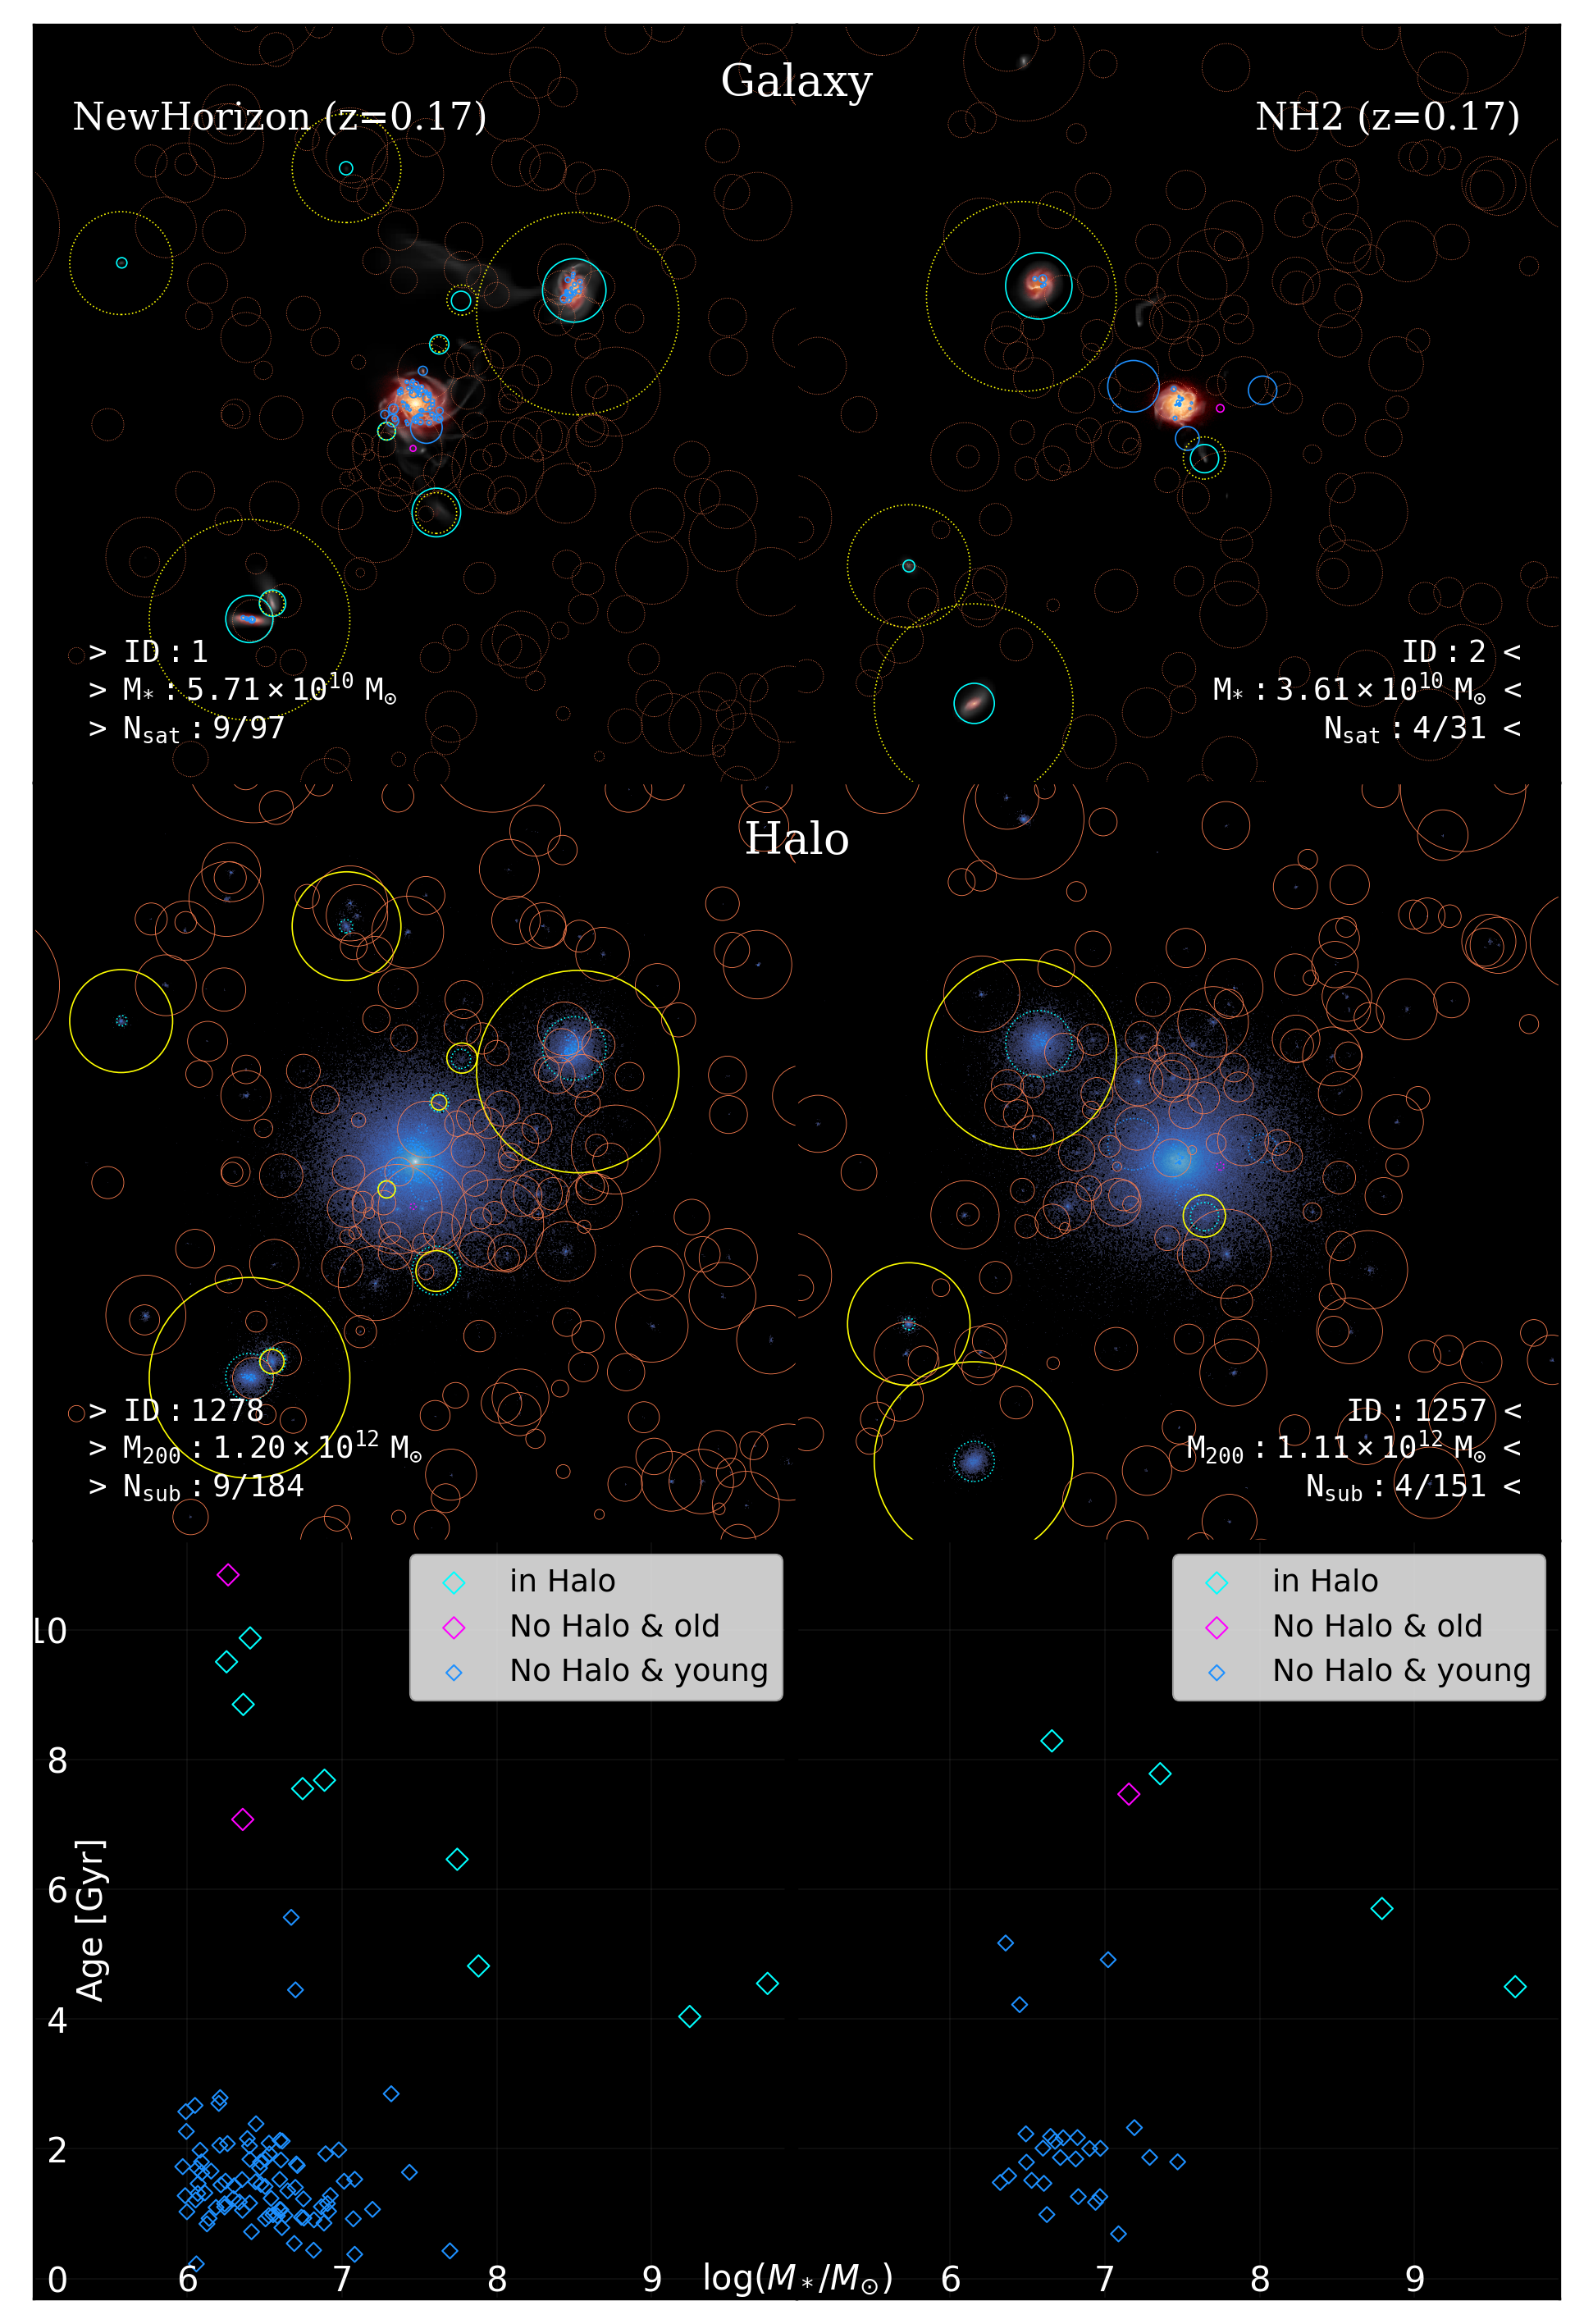

In [86]:
print(" > Drawing...")
fig, axes, cax = MakeSub_nolabel(3,2, cbar_loc='no', aspect='equal', dpi=300, size_factor=4)

# NH Galaxies
ax = axes[0,0]; ax.set_facecolor("k")
ax.imshow(combine1, origin='lower', extent=[*snap1.box[0], *snap1.box[1]])
host1s = []
real1s = []
for i, isat in enumerate(sat1s):
    if(isat['halo_id'] in sub1s['id'])&(isat['central']):
        color = 'cyan'
        lw = 0.4
        host1s.append(isat['halo_id'])
        real1s.append(isat['id'])
    else:
        color = 'dodgerblue'
        if(age1s[i]> 6): color='magenta'
        lw = 0.4
    cir = plt.Circle((isat['x'], isat['y']), isat['r'], color=color, fill=False, ls='-', lw=lw)
    ax.add_patch(cir)
    cir = plt.Circle((isat['x'], isat['y']), isat['r'], color=color, fill=False, ls=':', lw=lw)
    axes[1,0].add_patch(cir)
ax.text(0.05, 0.90, f"NewHorizon (z={1/snap1.aexp-1:.2f})", ha='left', va='top', color='w', fontsize=11, transform=ax.transAxes, family='DejaVu Serif')
ax.text(0.05, 0.05+0.05*2, fr"$\mathtt{{\ >\ ID: {MWA1['id']} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
a = MWA1['m'] / 10**int(np.log10(MWA1['m']))
b = int(np.log10(MWA1['m']))
ax.text(0.05, 0.05+0.05*1, fr"$\mathtt{{\ >\ M_{{*}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
ax.text(0.05, 0.05+0.05*0, fr"$\mathtt{{\ >\ N_{{sat}}: {len(real1s)}/{len(sat1s)} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)


# NH2 Galaxies
ax = axes[0,1]; ax.set_facecolor("k")
ax.imshow(combine2, origin='lower', extent=[*snap2.box[0], *snap2.box[1]])
host2s = []
real2s = []
for i, isat in enumerate(sat2s):
    if(isat['halo_id'] in sub2s['id'])&(isat['central']):
        color = 'cyan'
        lw = 0.4
        host2s.append(isat['halo_id'])
        real2s.append(isat['id'])
    else:
        color = 'dodgerblue'
        if(age2s[i]> 6): color='magenta'
        lw = 0.4
    cir = plt.Circle((isat['x'], isat['y']), isat['r'], color=color, fill=False, ls='-', lw=lw)
    ax.add_patch(cir)
    cir = plt.Circle((isat['x'], isat['y']), isat['r'], color=color, fill=False, ls=':', lw=lw)
    axes[1,1].add_patch(cir)
ax.text(0.95, 0.90, f"NH2 (z={1/snap2.aexp-1:.2f})", ha='right', va='top', color='w', fontsize=11, transform=ax.transAxes, family='DejaVu Serif')
ax.text(0.95, 0.05+0.05*2, fr"$\mathtt{{ID: {MWA2['id']}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
a = MWA2['m'] / 10**int(np.log10(MWA2['m']))
b = int(np.log10(MWA2['m']))
ax.text(0.95, 0.05+0.05*1, fr"$\mathtt{{M_{{*}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
ax.text(0.95, 0.05+0.05*0, fr"$\mathtt{{N_{{sat}}: {len(real2s)}/{len(sat2s)}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)

xy_fig = axes[0,0].transAxes.transform((1,0.95))
xy_fig = fig.transFigure.inverted().transform(xy_fig)
fig.text(xy_fig[0], xy_fig[1], "Galaxy", ha='center', va='top', color='w', fontsize=13, family='DejaVu Serif')

# NH Halos
ax = axes[1,0]; ax.set_facecolor("k")
ax.imshow(np.log10(dmmap1), origin='lower', extent=[*snap1.box[0], *snap1.box[1]], cmap=cmr.arctic, vmax=vmax_dm, vmin=vmin_dm)
for i, isub in enumerate(sub1s):
    color = 'yellow' if(isub['id'] in host1s) else 'coral'
    lw = 0.4 if(isub['id'] in host1s) else 0.2
    cir = plt.Circle((isub['x'], isub['y']), isub['rvir'], color=color, fill=False, ls='-', lw=lw)
    ax.add_patch(cir)
    cir = plt.Circle((isub['x'], isub['y']), isub['rvir'], color=color, fill=False, ls=':', lw=lw)
    axes[0,0].add_patch(cir)
ax.text(0.05, 0.05+0.05*2, fr"$\mathtt{{\ >\ ID: {MWA1['halo_id']} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
a = MWA1['m200'] / 10**int(np.log10(MWA1['m200']))
b = int(np.log10(MWA1['m200']))
ax.text(0.05, 0.05+0.05*1, fr"$\mathtt{{\ >\ M_{{200}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
ax.text(0.05, 0.05+0.05*0, fr"$\mathtt{{\ >\ N_{{sub}}: {len(host1s)}/{len(sub1s)} }}$", ha='left', va='bottom', color='w', fontsize=9, transform=ax.transAxes)

# NH2 Halos
ax = axes[1,1]; ax.set_facecolor("k")
ax.imshow(np.log10(dmmap2), origin='lower', extent=[*snap2.box[0], *snap2.box[1]], cmap=cmr.arctic, vmax=vmax_dm, vmin=vmin_dm)
for i, isub in enumerate(sub2s):
    color = 'yellow' if(isub['id'] in host2s) else 'coral'
    lw = 0.4 if(isub['id'] in host2s) else 0.2
    cir = plt.Circle((isub['x'], isub['y']), isub['rvir'], color=color, fill=False, ls='-', lw=lw)
    ax.add_patch(cir)
    cir = plt.Circle((isub['x'], isub['y']), isub['rvir'], color=color, fill=False, ls=':', lw=lw)
    axes[0,1].add_patch(cir)
ax.text(0.95, 0.05+0.05*2, fr"$\mathtt{{ ID: {MWA2['halo_id']}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
a = MWA2['m200'] / 10**int(np.log10(MWA2['m200']))
b = int(np.log10(MWA2['m200']))
ax.text(0.95, 0.05+0.05*1, fr"$\mathtt{{ M_{{200}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
ax.text(0.95, 0.05+0.05*0, fr"$\mathtt{{ N_{{sub}}: {len(host2s)}/{len(sub2s)}\ <\ }}$", ha='right', va='bottom', color='w', fontsize=9, transform=ax.transAxes)
xy_fig = axes[1,0].transAxes.transform((1,0.95))
xy_fig = fig.transFigure.inverted().transform(xy_fig)
fig.text(xy_fig[0], xy_fig[1], "Halo", ha='center', va='top', color='w', fontsize=13, family='DejaVu Serif')

# Check physical properties
ax = axes[2,0]
ax.set_facecolor("k")
ind = np.isin(sat1s['id'], real1s)
ax.scatter(np.log10(sat1s['m'])[ind], age1s[ind], edgecolors='cyan', label='in Halo', facecolors='none', s=20, marker='D', lw=0.5)
ind1 = (~ind)&(age1s>6)
ax.scatter(np.log10(sat1s['m'])[ind1], age1s[ind1], edgecolors='magenta', label='No Halo & old', facecolors='none', s=20, marker='D', lw=0.5)
ind1 = (~ind)&(age1s<6)
ax.scatter(np.log10(sat1s['m'])[ind1], age1s[ind1], edgecolors='dodgerblue', label='No Halo & young', facecolors='none', s=10, marker='D', lw=0.5)
ax.legend(loc='upper right', fontsize=9)
ax.set_ylabel("Age [Gyr]")
ax.set_xlim(5.01,)
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_major_locator(ticker.AutoLocator())

label_to_in('y', ax, hide_tick=True)
label_to_in('x', ax, hide_tick=True)
xlim = ax.get_xlim(); ylim = ax.get_ylim()
ax.axis('auto')
ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.grid(color='grey', alpha=0.5, lw=0.1)

ax = axes[2,1]
ax.set_facecolor("k")
ind = np.isin(sat2s['id'], real2s)
ax.scatter(np.log10(sat2s['m'])[ind], age2s[ind], edgecolors='cyan', label='in Halo', facecolors='none', s=20, marker='D', lw=0.5)
ind2 = (~ind)&(age2s>6)
ax.scatter(np.log10(sat2s['m'])[ind2], age2s[ind2], edgecolors='magenta', label='No Halo & old', facecolors='none', s=20, marker='D', lw=0.5)
ind2 = (~ind)&(age2s<6)
ax.scatter(np.log10(sat2s['m'])[ind2], age2s[ind2], edgecolors='dodgerblue', label='No Halo & young', facecolors='none', s=10, marker='D', lw=0.5)
ax.legend(loc='upper right', fontsize=9)
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.set_yticklabels([])
ax.xaxis.set_major_locator(ticker.AutoLocator())
label_to_in('x', ax, hide_tick=True)
ax.axis('auto')
ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.grid(color='grey', alpha=0.5, lw=0.1)

xy_fig = axes[2,0].transAxes.transform((1,0.05))
xy_fig = fig.transFigure.inverted().transform(xy_fig)
fig.text(xy_fig[0], xy_fig[1], r"log($M_* / M_{\odot}$)", ha='center', va='bottom', color='w')

plt.show()